In [1]:
%load_ext autoreload
%autoreload 2
from experiment.experiment import Experiment
from models.tensorflow.monde import Monde
from conf import conf
from models.tensorflow.conf import tf_conf
from experiment.hyper_param_opt import GridSearch
from models.tensorflow.tf_simple_train_eval import TfSimpleTrainEvalModelFactory
from skopt.space import Categorical
from models.tensorflow.utils import get_eval_inputs,get_inputs
from data.data_utils import DataLoader
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from bokeh.palettes import Category10_5 as colors
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
import pandas as pd
from functools import reduce
from experiment.experiment import InMemoryCollector
from copy import copy
from sklearn.metrics import roc_curve,auc,precision_recall_curve,average_precision_score
from sklearn.ensemble import RandomForestClassifier
import os
from sklearn.utils.fixes import signature
from scipy import stats
from itertools import combinations

In [2]:
output_notebook()

Loading BokehJS ...

In [3]:
exp = Experiment('classification/fx_3')
conf.num_workers = 1
conf.visible_device_list = [0]
exp.load(model_name="Monde_const_cov")

In [4]:
exp.best_model_params

{'nl1': 2,
 'sl1': 100,
 'nl2': 4,
 'sxl2': 30,
 'sl2': 100,
 'pt': 'square',
 'bs': 128,
 'clr': 0.05,
 'rs': 1,
 'ts': 1,
 'bsi': 3,
 'bsip': 20,
 'opt': 'AdamOptimizer',
 'opt_lr': 0.001}

In [3]:
exp.data_loader.figure_train();

In [6]:
y_95_percentile = np.percentile(exp.data_loader.train_y, 95,axis=0)

In [ ]:
result_test = exp.predict_best_model({'x':exp.data_loader.test_x, 'y':(np.ones(exp.data_loader.test_y.shape)*y_95_percentile).astype(np.float32)}, InMemoryCollector())

In [8]:
std_norm_mv = stats.multivariate_normal(mean=[0]*exp.data_loader.test_y.shape[1], cov=result_test['cor'][0])
quantiles = [stats.norm.ppf(cdf) for cdf in result_test['cdfs']]
test_score = 1-std_norm_mv.cdf(np.concatenate(quantiles, axis=1))

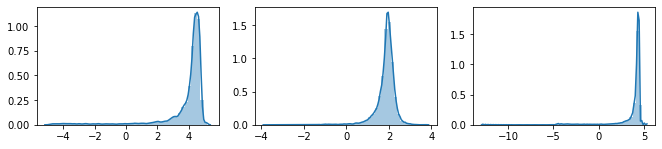

In [9]:
plt.figure(figsize=(15,10))
for i in range(3):
    plt.subplot(4,4, i+1)
    sns.distplot(quantiles[i])
#     sns.distplot(result_test['cdfs'][i])
plt.show();

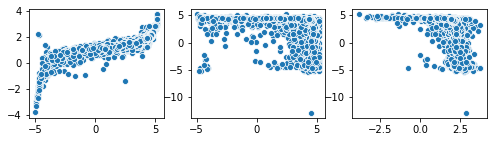

In [10]:
plt.figure(figsize=(14,14))
for i,(x,y) in enumerate(combinations(range(3),2)):
    plt.subplot(6,5, i+1)
    sns.scatterplot(quantiles[x].ravel(),quantiles[y].ravel())
plt.show();

In [11]:
true_label_test = np.any(exp.data_loader.test_y > y_95_percentile, axis=1)

In [12]:
fpr, tpr, thresholds = roc_curve(true_label_test, test_score)
roc_auc = auc(fpr, tpr)

<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver Operating Characteristic, Area=0.94')

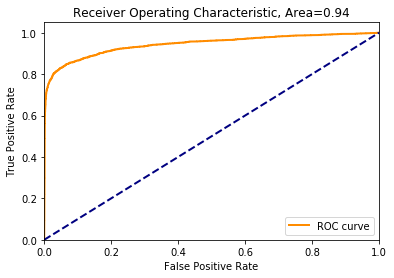

In [13]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic, Area={0:0.2f}'.format(roc_auc))
plt.legend(loc="lower right")
# plt.show();
plt.savefig('figures/roc_monde_cost_cov.png',dpi=1200)

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

(0.0, 1.05)

(0.0, 1.0)

Text(0.5, 1.0, 'Precision-Recall curve, Area=0.86')

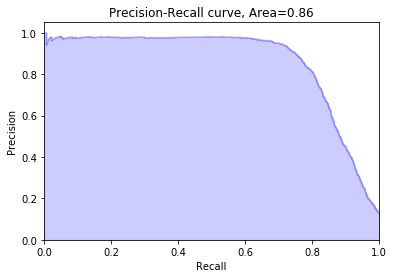

In [14]:
precision, recall, _ = precision_recall_curve(true_label_test, test_score)
average_precision = average_precision_score(true_label_test, test_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve, Area={0:0.2f}'.format(
          average_precision))
# plt.show();
plt.savefig('figures/pr_monde_cost_cov.png',dpi=1200)